# Análise dos Focos de Incendio

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('focos_incendio_geral.csv')

In [12]:
df['data_pas'] = pd.to_datetime(df['data_pas'])

## 2. Exploração Inicial


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem de focos por bioma
bioma_counts = df['bioma'].value_counts()
bioma_counts.plot(kind='bar', title='Focos de Incêndio por Bioma')
plt.xlabel('Bioma')
plt.ylabel('Número de Focos')
plt.show()

# Distribuição temporal dos focos de incêndio
df.set_index('data_pas')['foco_id'].resample('M').count().plot(title='Distribuição Temporal dos Focos de Incêndio', figsize=(12, 6))
plt.xlabel('Ano')
plt.ylabel('Número de Focos')
plt.show()


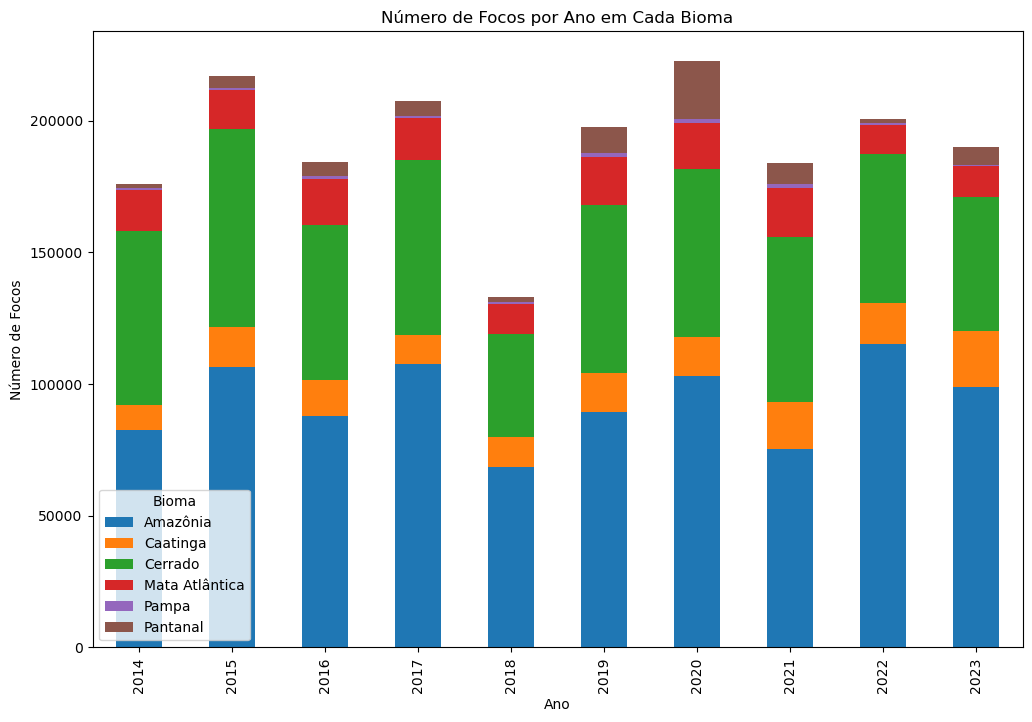

In [13]:
# Extraindo o ano da coluna data_pas
df['ano'] = df['data_pas'].dt.year

# Contagem do número de focos por ano em cada bioma
focos_por_ano_bioma = df.groupby(['ano', 'bioma']).size().unstack(fill_value=0)

# Plotando o número de focos por ano em cada bioma
focos_por_ano_bioma.plot(kind='bar', stacked=True, figsize=(12, 8), title='Número de Focos por Ano em Cada Bioma')
plt.xlabel('Ano')
plt.ylabel('Número de Focos')
plt.legend(title='Bioma')
plt.show()


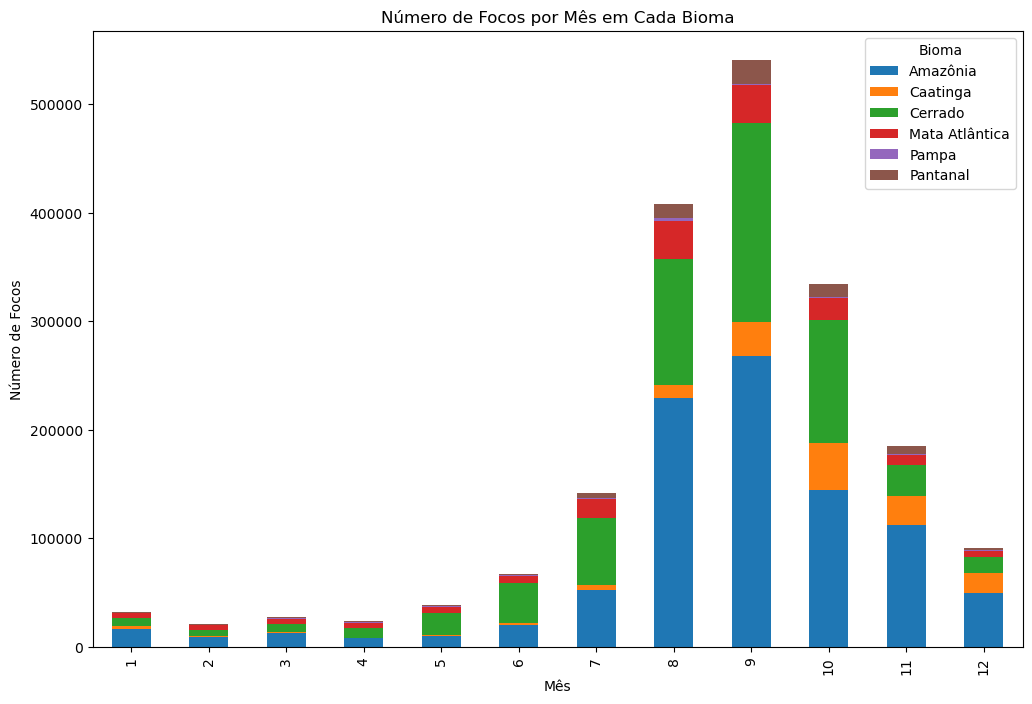

In [14]:
# Extraindo o mês da coluna data_pas
df['mes'] = df['data_pas'].dt.month

# Contagem do número de focos por mês em cada bioma
focos_por_mes_bioma = df.groupby(['mes', 'bioma']).size().unstack(fill_value=0)

# Plotando o número de focos por mês em cada bioma
focos_por_mes_bioma.plot(kind='bar', stacked=True, figsize=(12, 8), title='Número de Focos por Mês em Cada Bioma')
plt.xlabel('Mês')
plt.ylabel('Número de Focos')
plt.legend(title='Bioma')
plt.show()


### Avanço em Quilômetros dos Focos de Incêndio por Mês em Cada Bioma
Para calcular o avanço em quilômetros, usaremos a fórmula Haversine para calcular a distância entre coordenadas geográficas consecutivas dentro do mesmo bioma e mês.

python


In [18]:
from geopy.distance import geodesic

# Ordenando os dados por bioma e data
df_sorted = df.sort_values(by=['bioma', 'data_pas'])

# Função para calcular a distância entre coordenadas consecutivas
def calculate_distance(group):
    group = group.sort_values(by='data_pas')
    distances = [0]  # Primeira distância é zero (nenhuma comparação anterior)
    for i in range(1, len(group)):
        coords_1 = (group.iloc[i-1]['lat'], group.iloc[i-1]['lon'])
        coords_2 = (group.iloc[i]['lat'], group.iloc[i]['lon'])
        distance = geodesic(coords_1, coords_2).kilometers
        distances.append(distance)
    return pd.Series(distances, index=group.index)

# Aplicando a função para calcular a distância dentro de cada grupo (bioma, ano, mês)
df_sorted['dist_km'] = df_sorted.groupby(['bioma', df_sorted['data_pas'].dt.year, df_sorted['data_pas'].dt.month]).apply(calculate_distance)

# Agrupando as distâncias por bioma e mês (somando as distâncias)
distancia_por_mes_bioma = df_sorted.groupby(['bioma', df_sorted['data_pas'].dt.year, df_sorted['data_pas'].dt.month])['dist_km'].sum().unstack(level=0, fill_value=0)

# Plotando o avanço de quilômetros por mês em cada bioma
distancia_por_mes_bioma.plot(kind='line', figsize=(12, 8), title='Avanço de Focos de Incêndio (Km) por Mês em Cada Bioma')
plt.xlabel('Ano-Mês')
plt.ylabel('Distância em Km')
plt.legend(title='Bioma')
plt.show()


c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


ValueError: Latitude must be in the [-90; 90] range.

## 3. Análise Series Temporais

In [ ]:
import statsmodels.api as sm

# Decomposição de Série Temporal (exemplo com um bioma específico, e.g., Amazônia)
df_amazonia = df[df['bioma'] == 'Amazônia']
df_amazonia.set_index('data_pas', inplace=True)
df_amazonia_resampled = df_amazonia['foco_id'].resample('M').count()

decomposition = sm.tsa.seasonal_decompose(df_amazonia_resampled, model='additive')
decomposition.plot()
plt.show()

# Modelagem ARIMA/SARIMA
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_amazonia_resampled, order=(5,1,0))  # Exemplo com ARIMA(5,1,0)
results = model.fit()
results.plot_diagnostics(figsize=(12, 8))
plt.show()


## 4. Identificação de Padrões Espaciais Temporais(Cluster)

In [ ]:
from sklearn.cluster import DBSCAN
import geopandas as gpd
from shapely.geometry import Point

# Convertendo os dados para GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

# Clustering DBSCAN
coords = gdf[['lat', 'lon']].values
db = DBSCAN(eps=0.1, min_samples=50).fit(coords)
gdf['cluster'] = db.labels_

# Plotando os clusters
gdf.plot(column='cluster', cmap='tab20', legend=True, figsize=(10, 10))
plt.title('Clusters de Incêndios Identificados pelo DBSCAN')
plt.show()


## 5. Modelagem Espacial Temporal Preditiva

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Extraindo características temporais
df['ano'] = df['data_pas'].dt.year
df['mes'] = df['data_pas'].dt.month
df['dia'] = df['data_pas'].dt.day

# Criando conjunto de treino e teste
X = df[['lat', 'lon', 'ano', 'mes', 'dia']]
y = df['bioma']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Avaliando o modelo
y_pred = model_rf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f'Acurácia do modelo: {accuracy:.2f}')


## 6. Detecção de Anomalias em focos de incêndio 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest

# Supondo que você já tenha a série temporal resampleada (exemplo usando a Amazônia)
df_amazonia = df[df['bioma'] == 'Amazônia']
df_amazonia.set_index('data_pas', inplace=True)
df_amazonia_resampled = df_amazonia['foco_id'].resample('M').count()

# Decompondo a série temporal para separar a tendência e sazonalidade
decomposition = seasonal_decompose(df_amazonia_resampled, model='additive')
residual = decomposition.resid.dropna()

# Usando Isolation Forest para detecção de anomalias
model = IsolationForest(contamination=0.01)  # Ajuste a contaminação conforme necessário
residual = residual.values.reshape(-1, 1)
model.fit(residual)
df_amazonia_resampled['anomaly'] = model.predict(residual)

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(df_amazonia_resampled.index, df_amazonia_resampled['foco_id'], label='Focos de Incêndio')
plt.scatter(df_amazonia_resampled[df_amazonia_resampled['anomaly'] == -1].index,
            df_amazonia_resampled[df_amazonia_resampled['anomaly'] == -1]['foco_id'],
            color='red', label='Anomalias', marker='o')
plt.title('Detecção de Anomalias nos Focos de Incêndio na Amazônia')
plt.xlabel('Data')
plt.ylabel('Número de Focos')
plt.legend()
plt.show()
